In [155]:
# data originally came from
# http://archive.ics.uci.edu/ml/datasets/Adult

In [156]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [157]:
data = pd.read_csv('adult.data', header = None)
data.columns = ['age','workclass','fnlwgt','education','education-num','marital-status','occupation',\
                'relationship','race','sex','capital-gain','capital-loss','hours-per-week','native-country','target']

### Preprocessings

In [158]:
data.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
target            0
dtype: int64

In [159]:
data.shape

(32561, 15)

In [160]:
# categorical data

categorical = ['workclass','education','marital-status','occupation','race','relationship','sex','native-country','target']

In [161]:
from sklearn.preprocessing import OneHotEncoder

dfs = []
for c in categorical:
    enc = OneHotEncoder()
    enc.fit(data[c].values.reshape(-1,1))
    temp = enc.transform(data[c].values.reshape(-1,1)).toarray()
    new_columns = enc.categories_
    
    if len(new_columns[0]) == 2:
        new_columns = np.array([[new_columns[0][1]]])
        temp = temp[:,1]
    new_columns = [c+'_'+I for I in new_columns[0]]
    dfs.append(pd.DataFrame(columns=new_columns,data=temp))
    
    
    
categorical_data = pd.concat(dfs,1)
continuous_labels = list(set(data.columns) - set(categorical))
data = pd.concat([data[continuous_labels], categorical_data],1)

Y = data['target_ >50K']
cols = list(data.columns)
cols.remove('target_ >50K')
X = data[cols]

X_train, y_train = X,Y

In [162]:
test_data = pd.read_csv('adult.test',skiprows = 1, header = None)
test_data.columns = ['age','workclass','fnlwgt','education','education-num','marital-status','occupation',\
                'relationship','race','sex','capital-gain','capital-loss','hours-per-week','native-country','target']
test_data.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
target            0
dtype: int64

In [163]:
from sklearn.preprocessing import OneHotEncoder

dfs = []
for c in categorical:
    enc = OneHotEncoder()
    enc.fit(test_data[c].values.reshape(-1,1))
    temp = enc.transform(test_data[c].values.reshape(-1,1)).toarray()
    new_columns = enc.categories_
    
    if len(new_columns[0]) == 2:
        new_columns = np.array([[new_columns[0][1]]])
        temp = temp[:,1]
    new_columns = [c+'_'+I for I in new_columns[0]]
    dfs.append(pd.DataFrame(columns=new_columns,data=temp))
    
    
    
categorical_data = pd.concat(dfs,1)
continuous_labels = list(set(test_data.columns) - set(categorical))
test_data = pd.concat([test_data[continuous_labels], categorical_data],1)

Y = test_data['target_ >50K.']
cols = list(test_data.columns)
cols.remove('target_ >50K.')
X = test_data[cols]

for cols in list(set(X_train.columns) - set(X_test.columns)):
    X[cols] = 0

X_test, y_test = X,Y

In [164]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

In [165]:
log = LogisticRegression()
log.fit(X_train.values, y_train.values);

ranf = RandomForestClassifier()
ranf.fit(X_train.values, y_train.values);

tree_model = DecisionTreeClassifier()
tree_model.fit(X_train.values, y_train.values);


In [219]:
def get_TF_PN(y_pred, y_actual):

    TruePositives = 0
    TrueNegatives = 0
    FalsePositives = 0
    FalseNegatives = 0


    for i in range(len(y_actual)):
        if y_pred[i] == 1 and y_actual[i] == 1:
            TruePositives += 1
        elif y_pred[i] == 0 and y_actual[i] == 0:
            TrueNegatives += 1
        elif y_pred[i] == 0 and y_actual[i] == 1:
            FalseNegatives += 1
        elif y_pred[i] == 1 and y_actual[i] == 0:
            FalsePositives += 1
        else:
            raise NotImplemented
            
    return TruePositives, TrueNegatives, FalsePositives, FalseNegatives


def get_TPR_FPR(y_pred, y_actual):
    TruePositives, TrueNegatives, FalsePositives, FalseNegatives = get_TF_PN(y_pred, y_actual)
    TruePositiveRate = TruePositives/(TruePositives + FalseNegatives)
    FalsePositiveRate = FalsePositives/(FalsePositives + TrueNegatives)
    
    return TruePositiveRate, FalsePositiveRate



def AUC(FPR, TPR):
    """
    Using standard 
    """

    FPR = FPR[::-1]
    TPR = TPR[::-1]

    FPR = [0.0]+FPR
    TPR = [0.0]+TPR


    assert(len(FPR) == len(TPR))
    areas = []
    for i in range(1,len(FPR)):
        areas.append(((FPR[i] - FPR[i-1])*(TPR[i] - TPR[i-1]))/2 + (1-FPR[i])*(TPR[i]-TPR[i-1]))

    return np.sum(areas)

Working on RanFor



Working on Logis



Working on Tree


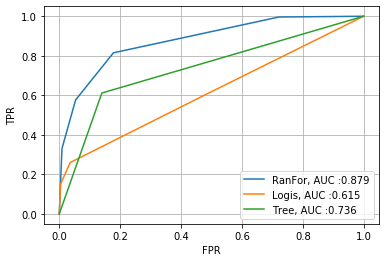

In [221]:
from tqdm import tqdm_notebook
thresholds = np.linspace(0,1,5)

models = [ranf, log, tree_model]
model_label = ['RanFor','Logis','Tree']

for i,model in enumerate(models):
    print('Working on '+model_label[i])
    pred_probs = model.predict_proba(X_test.values) #[0,1]
    TPR, FPR = [1.0], [1.0]
    for t in tqdm_notebook(thresholds):

        y_actual = y_test
        y_pred_probs = pred_probs[:,1]
        y_pred = np.array(y_pred_probs > t,int)
        tpr, fpr = get_TPR_FPR(y_pred, y_actual)
        TPR.append(tpr)
        FPR.append(fpr)
        
    TPR.append(0.0)
    FPR.append(0.0)
    
    auc = AUC(FPR,TPR).round(3)

    plt.plot(FPR, TPR,label = model_label[i]+', AUC :' + str(auc))
plt.legend()
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.grid()
plt.show()

# Some notes about AUC/ROC

As seen from above the ROC is the receiver operating characteristic. It is a curve which plots the TPR (true positive rate) against the FPR (false positive rate). 

\begin{equation} \text{TPR} = \frac{\text{TP}}{\text{TP} + \text{FN}} \end{equation}

Namely, the true positive devided by all positive observations.

\begin{equation} \text{FPR} = \frac{\text{FP}}{\text{FP} + \text{TN}} \end{equation}

Namely, the false positive devided by all the negative observations.

We fundamentally would want to maximise TPR, whilst minimising FPR. Thus : The ROC curve shows the trade-off between sensitivity (or TPR) and specificity (1 – FPR). Classifiers that give curves closer to the top-left corner indicate a better performance. As a baseline, a random classifier is expected to give points lying along the diagonal (FPR = TPR). The closer the curve comes to the 45-degree diagonal of the ROC space, the less accurate the test.

The points are varied associated to the threshold of the decision boundary. E.g. for logisitic regression - a binary classifier is deamed positive if the sigmoid functions gives > 0.5, whilst returning negative if <= 0.5. The ROC looks at the effect of changing this threshold as seeing how the FPR,TPR changes.

To compare different classifiers, it can be useful to summarize the performance of each classifier into a single measure. One common approach is to calculate the area under the ROC curve, which is abbreviated to AUC. It is equivalent to the probability that a randomly chosen positive instance is ranked higher than a randomly chosen negative instance, i.e. it is equivalent to the two sample Wilcoxon rank-sum statistic.

A classifier with high AUC can occassionally score worse in a specific region than another classifier with lower AUC. But in practice, the AUC performs well as a general measure of predictive accuracy.